In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [2]:
# Load vmem simulation data
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

plot_vmem_file_paths = [
    os.path.join(base_dir, f'plot_data_neo_{i}.npy')
    for i in range(16)
]

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [3]:
prop_names = {'total_len': 'Total z Length',  
              'asymmetry_factor': 'Asymmetry-Factor',
              'soma_diam': '$d_s$',
              'avg_z_diam': '$d_d$'}

selected_properties = ['total_len', 'soma_diam', 'avg_z_diam', 'asymmetry_factor']

In [4]:
def scatter_plot_all_properties_with_reg_two_freq(
        amp_data, properties, prop_names, freqs=(10, 1000)):

    cols = len(properties)
    rows = 2

    fig, axes = plt.subplots(nrows=rows, ncols=cols,
                             figsize=(2.5*cols, 2.6*rows),)
                            #  sharex='col')

    legend_handles = {}

    # --- consistent styling ---
    marker_size = 14
    edgecolor = 'grey'
    edge_lw = 0.3

    for row_idx, at_freq in enumerate(freqs):

        for col_idx, property_name in enumerate(properties):
            ax = axes[row_idx, col_idx]

            x_values = []
            y_values = []

            for cell_name, values in amp_data.items():

                property_value = values[property_name]

                if at_freq in values['freq']:
                    freq_idx = values['freq'].index(at_freq)
                    soma_amp_at_freqHz = values['soma_amp'][freq_idx]

                    if 'PC' in cell_name or 'SP' in cell_name:
                        color = 'tab:green'
                        label = 'Pyramidal cells'
                        alpha = 0.4
                    elif 'SS' in cell_name:
                        color = 'tab:purple'
                        label = 'Spiny stellate cells'
                        alpha = 0.9
                    else:
                        color = 'tab:orange'
                        label = 'Inhibitory neurons'
                        alpha = 0.4

                    sc = ax.scatter(
                        soma_amp_at_freqHz,
                        property_value,
                        s=marker_size,
                        marker='o',
                        facecolor=color,
                        edgecolor=color,
                        linewidth=edge_lw,
                        alpha=alpha,
                        zorder=3,
                        label=label
                    )

                    if label not in legend_handles:
                        legend_handles[label] = sc

                    x_values.append(soma_amp_at_freqHz)
                    y_values.append(property_value)

            # ----- Linear regression -----
            if len(x_values) > 1:
                x_np = np.array(x_values)
                y_np = np.array(y_values)

                regressor = LinearRegression()
                regressor.fit(x_np.reshape(-1, 1), y_np)

                # sort for clean line
                x_sorted_idx = np.argsort(x_np)
                x_sorted = x_np[x_sorted_idx]
                y_pred_sorted = regressor.predict(
                    x_sorted.reshape(-1, 1)
                )

                r2 = r2_score(y_np,
                              regressor.predict(x_np.reshape(-1, 1)))

                ax.plot(
                    x_sorted,
                    y_pred_sorted,
                    color='black',
                    linewidth=1.5
                )

                if property_name == 'asymmetry_factor' and at_freq == 10:
                    r_loc_x = 0.8
                else: r_loc_x = 0.96
                ax.text(
                    r_loc_x, 0.96,
                    rf'$R^2 = {r2:.2f}$',
                    transform=ax.transAxes,
                    va='top',
                    ha='right',
                    bbox=dict(boxstyle='round',
                                  facecolor='white',
                                  alpha=0.5),
                    zorder=1
                )

            # ----- Labels -----
            ax.set_xlabel(r'Soma $V_m$ amplitude [mV]')

            if property_name == 'asymmetry_factor':
                ax.set_ylabel(prop_names[property_name])
            else:
                ax.set_ylabel(f'{prop_names[property_name]} [µm]')

            # subtle grid
            ax.grid(True, linestyle='--', linewidth=0.4,
                    alpha=0.4, zorder=1)

            # cleaner spines
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        # ----- Row Titles -----
        axes[row_idx, 0].set_title(
            f"{at_freq} Hz",
            loc='left',
            fontweight='bold'
        )

    # ----- Panel Letters -----
    axes[0, 0].text(-0.28, 1.08, 'A',
                    transform=axes[0, 0].transAxes,
                    fontsize=12,
                    fontweight='bold')

    axes[1, 0].text(-0.28, 1.08, 'B',
                    transform=axes[1, 0].transAxes,
                    fontsize=12,
                    fontweight='bold')

    # ----- Legend -----
    fig.legend(
        legend_handles.values(),
        legend_handles.keys(),
        loc='lower center',
        ncol=3,
        frameon=False,
        bbox_to_anchor=(0.5, -0.02)
    )

    plt.tight_layout(rect=[0, 0.06, 1, 1])

    plt.savefig(
        '/Users/susannedahle/Documents/Master/Code/fig_pdfs/figS3.pdf',
        bbox_inches="tight"
    )

    plt.show()

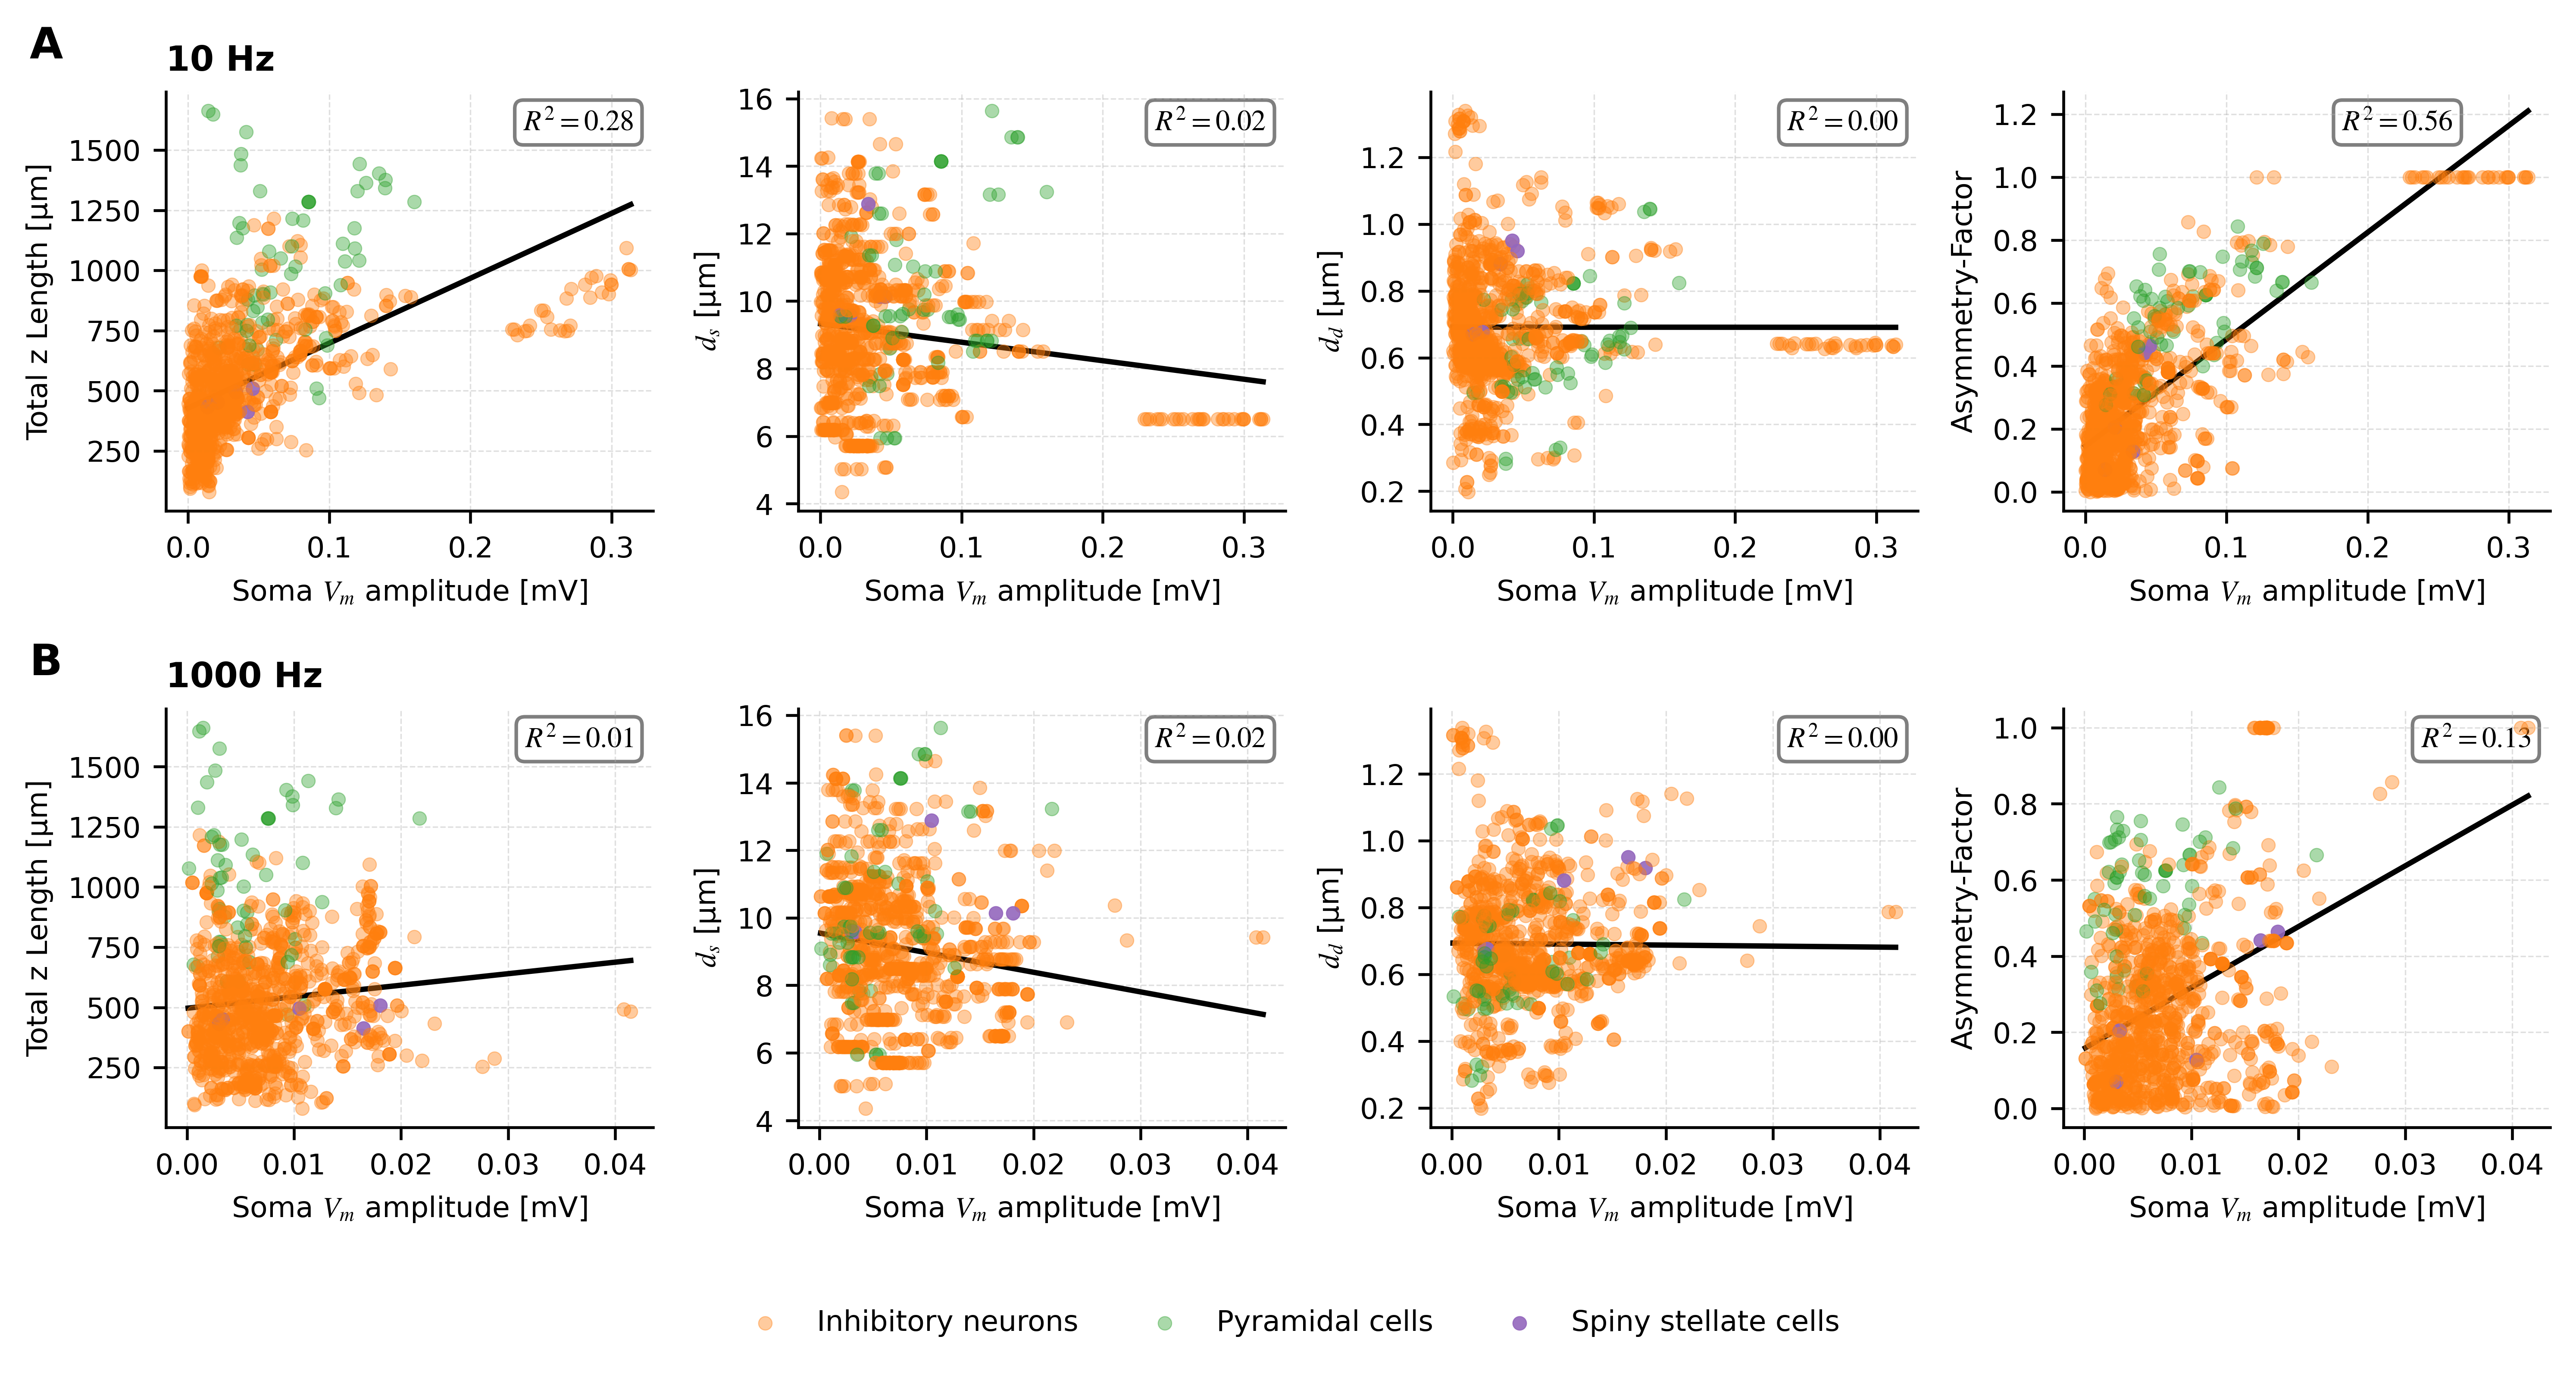

In [5]:
scatter_plot_all_properties_with_reg_two_freq(
    vmem_amp_data,
    selected_properties,
    prop_names,
    freqs=(10, 1000)
)